In [37]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2

%matplotlib inline

### Remove Perspective Skew

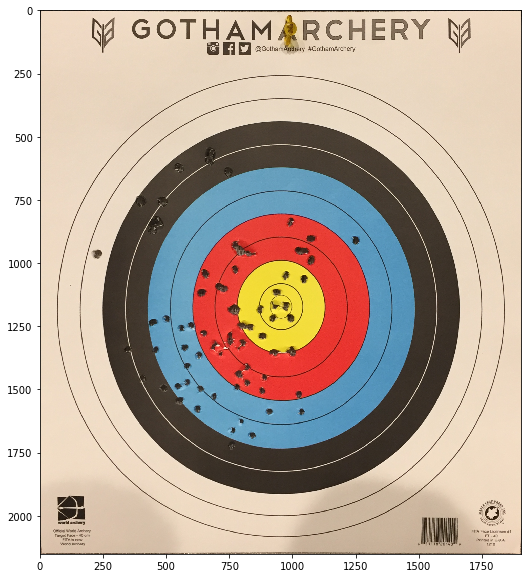

In [2]:
#img_file = '../img/raw/range/IMG_3539.JPG'
#img_file = '../img/raw/range/IMG_3542.JPG'
#img_file = '../img/raw/range/IMG_3544.JPG'
#img_file = '../img/raw/range/IMG_3557.JPG'
#img_file = '../img/raw/range/IMG_3558.JPG'
img_file = '../img/raw/range/IMG_3559.JPG'

frame_width = 600
blue_ratio = (9 + 7/16) / 16.5
width = 600
canny_t1 = 100
canny_t2 = 400
perim_pct = .015

img = cv2.imread(img_file, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
orig = img.copy()

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
height = int(width / img.shape[1] * img.shape[0])
gray = cv2.resize(gray, (width, height))
sigma_val = width // 15
d_val = width // 20

gray = cv2.bilateralFilter(gray, d_val, sigma_val, sigma_val)
edges = cv2.Canny(gray, canny_t1, canny_t2)
kernel = np.ones((4,4), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

_, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
paper = None
max_perim = 0
for c in contours:
    perim = cv2.arcLength(c, True)
    if perim > max_perim:
        approx = cv2.approxPolyDP(c, perim * perim_pct, True)
        if len(approx) == 4:
            paper = approx
            max_perim = perim

gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
if type(paper) != type(None):
    gray = cv2.drawContours(gray, paper, -1, (255, 0, 0), 10)
    
paper = paper.reshape(4, 2)
bounds = paper.copy()
sums = np.sum(paper, axis=1)
diffs = np.diff(paper, axis=1)
bounds[0] = paper[np.argmin(sums)]
bounds[1] = paper[np.argmin(diffs)]
bounds[2] = paper[np.argmax(sums)]
bounds[3] = paper[np.argmax(diffs)]
bounds = (bounds * (img.shape[1] / width)).astype('float32')

top_w = np.linalg.norm(bounds[0] - bounds[1])
btm_w = np.linalg.norm(bounds[2] - bounds[3])
lft_h = np.linalg.norm(bounds[0] - bounds[3])
rgt_h = np.linalg.norm(bounds[1] - bounds[2])
new_w = int(min(top_w, btm_w))
new_h = int(min(lft_h, rgt_h))
new_bounds = np.array([
    [0, 0],
    [new_w, 0],
    [new_w, new_h],
    [0, new_h]
], dtype = 'float32')
M = cv2.getPerspectiveTransform(bounds, new_bounds)
img = cv2.warpPerspective(img, M, (new_w, new_h))
    
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show();

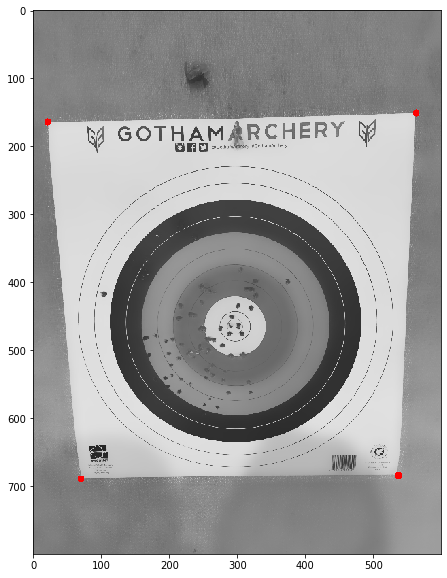

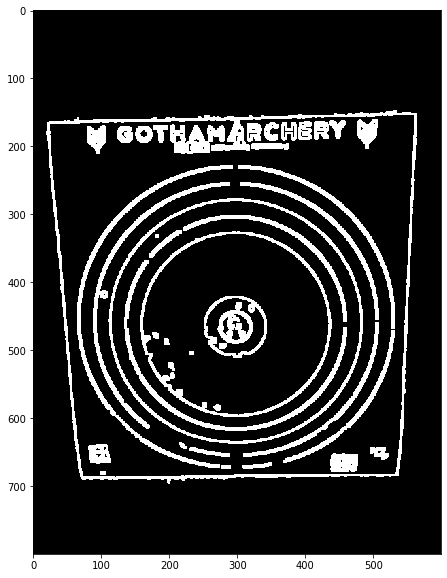

In [3]:
plt.figure(figsize=(10, 10))
plt.imshow(gray)
plt.show();

plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')
plt.show();

### Standardize Target Size

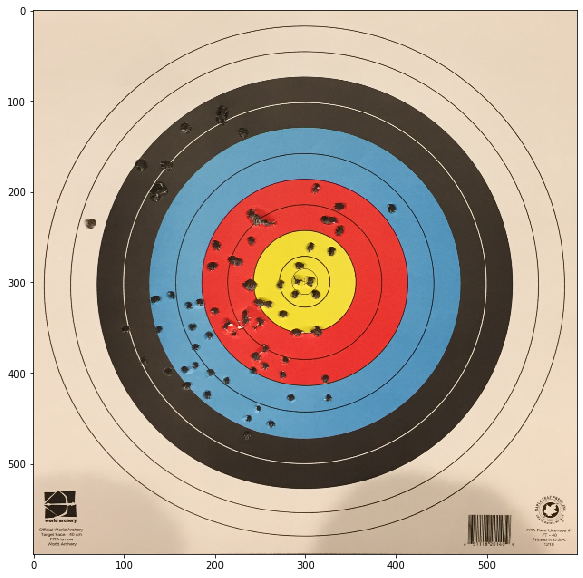

In [4]:
colors = {
    'yellow': [{'low': np.array([15, 130, 130]), 'high': np.array([45, 255, 255])}],
    'red': [{'low': np.array([165, 130, 130]), 'high': np.array([180, 255, 255])},
            {'low': np.array([0, 130, 130]), 'high': np.array([15, 255, 255])}],
    'blue': [{'low': np.array([80, 80, 80]), 'high': np.array([130, 255, 255])}],
}

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
knl_size = (width + height) // 550

circle_data = []
circle_contours = []
for key in colors.keys():
    mask = 0
    for rng in colors[key]:
        mask = cv2.bitwise_or(cv2.inRange(hsv, rng['low'], rng['high']), mask)
    kernel = np.ones((knl_size, knl_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    _, contours, __ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]
    idx = np.argsort(areas)[-1]
    M = cv2.moments(contours[idx])
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    circle_contours.append(contours[idx].copy())
    circle_data.append([areas[idx], center_x, center_y])
    
    '''
    out = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    out = cv2.drawContours(out, contours[idx], -1, (255, 0, 0), 20)
    out = cv2.circle(out, (center_x, center_y), 30, (0, 0, 255), -1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(out)
    plt.show();
    '''
    
circle_data = np.array(circle_data)
target_center = np.mean(circle_data[:, 1:], axis=0).astype(int)

x, y, w, h = cv2.boundingRect(circle_contours[-1])
blue_dim = blue_ratio * frame_width
scl_x = blue_dim / w
scl_y = blue_dim / h
img = cv2.resize(img, None, fx=scl_x, fy=scl_y)

border_size = frame_width // 10
img = cv2.copyMakeBorder(img, *([border_size] * 4), cv2.BORDER_REFLECT)
st_x = int(target_center[0] * scl_x + border_size - frame_width / 2)
st_y = int(target_center[1] * scl_y + border_size - frame_width / 2)
img = img[st_y:st_y+frame_width, st_x:st_x+frame_width]

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show();

#cv2.imwrite(img_file.replace('/raw/', '/out/'), img);

### Identify Arrow Holes

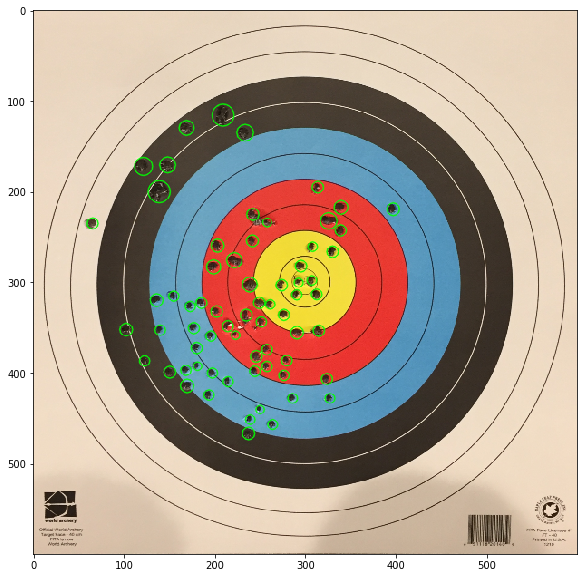

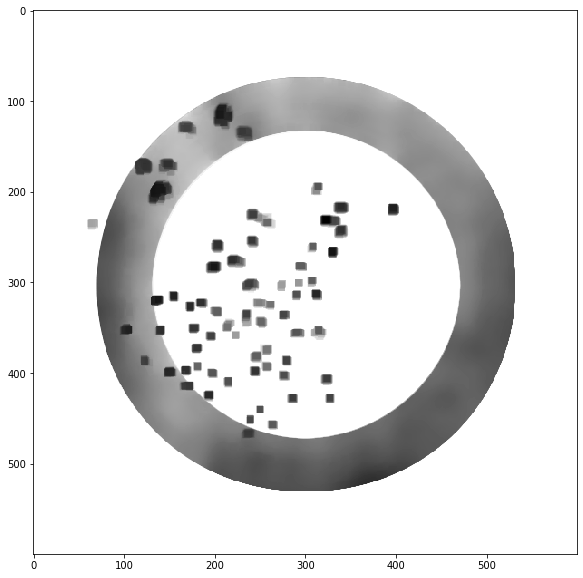

In [5]:
logos = np.array([
    [[10, 530], [50, 570]],
    [[470, 550], [530, 590]],
    [[550, 530], [590, 570]]
])
ref_size = 600
logos = (logos * frame_width / ref_size).astype(int)

mask = np.zeros((frame_width, frame_width), dtype=np.uint8)
for logo in logos:
    mask = cv2.rectangle(mask, tuple(logo[0]), tuple(logo[1]), 255, -1)
mask_inv = cv2.bitwise_not(mask)
    
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.blur(gray, (50,50))
gray = cv2.bitwise_and(gray, gray, mask=mask_inv)
blurred = cv2.bitwise_and(blurred, blurred, mask=mask)
gray = cv2.add(gray, blurred)


min_area = 50
max_area = 1000
white_limit = 160

kernel = np.ones((4,4), np.uint8)
gray = cv2.filter2D(gray, -1, kernel/8)
gray = cv2.erode(gray, kernel, iterations=2)
gray[gray > white_limit] = white_limit
gray = np.interp(gray, (gray.min(), gray.max()), (0, 255)).astype(np.uint8)

kernel = np.ones((20,20), np.uint8)
mask = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
mask = cv2.equalizeHist(mask)
_, mask = cv2.threshold(mask, white_limit, 255, cv2.THRESH_BINARY_INV)
mask_inv = cv2.bitwise_not(mask)

clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8,8))
gray = clahe.apply(gray)
kernel = np.ones((8,8), np.uint8)
ring_layer = cv2.bilateralFilter(gray, d_val, sigma_val, sigma_val)

ring_layer = cv2.bitwise_and(ring_layer, ring_layer, mask=mask)
gray = cv2.bitwise_and(gray, gray, mask=mask_inv)
gray = cv2.add(gray, ring_layer)

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = min_area
params.maxArea = max_area
params.filterByCircularity = True
params.minCircularity = .3
params.filterByConvexity = True
params.minConvexity = .3
params.filterByInertia = True
params.minInertiaRatio = .1

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)
out = cv2.drawKeypoints(img,
                        keypoints,
                        np.array([]),
                        (0,255,0),
                        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 10))
plt.imshow(out)
plt.show();

plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.show();

### Collect Arrow Hole Coordinates

In [56]:
pct_smallest = .2
overlap_penalty = .85

arrow_pts = []
arrow_sizes = []
for k in keypoints:
    arrow_pts.append(k.pt)
    arrow_sizes.append(k.size)
    
df = pd.DataFrame({'raw_coords':arrow_pts, 'size':arrow_sizes})

num_smallest = np.ceil(len(arrow_sizes) * pct_smallest).astype(int)
single_size = np.mean(np.sort(arrow_sizes)[:num_smallest]) * overlap_penalty
df['count'] = df['size'] // single_size
df['count'] = df['count'].replace(0, 1).astype(int)
df['count'].sum()

73

In [57]:
df.describe()

,size,count
count,67.000000,67.000000
mean,13.065354,1.089552
std,2.995673,0.287694
min,9.433981,1.000000
25%,11.376486,1.000000
50%,12.390028,1.000000
75%,13.944254,1.000000
max,24.341261,2.000000
